# Week 4 Lab Session: Random Walks and Monte Carlo Simulations

In this week's session, we will introduce content for our fourth week by looking at the very basics of how to leverage simulations in making guesses about the behavior of the market. We will take as a basis for our simulation today the idea of a Geometric Brownian Motion. The formula for this is given by

$$
\frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t
$$

Let's dissect this formula a little before running our code. The left side of the expression, $\frac{S_{t+dt}-S_t}{S_t}$, says that we are generating a value for the percent return of our portfolio between time steps $t+dt$ and $t$. The change in time $dt$ could be a week, an hour, a day, or a month, depending on the frequency with which we are sampling. There is some constant $\mu$ which represents the general trend of our portoflio (i.e. is the portfolio gaining or decreasing in value with every time step *on average*). Finallt, we have an expression $\sigma\sqrt{dt}\xi_t$ representing the random movement in a given time step, which has equal probability of going up or down, and is drawn from some normal distribution representing the size of this random noise.

When we generate simulated returns, we usually ignore the $\mu$ coefficient's decomposition since we only care about the net effective drift term and not what drives it. Let's develop a function that lets us simulate time steps from this Geometric Brownian Motion.

For this function, we will pass a series of arguments: the number of years to simulate, the number of scenarios to play out, the value of the drift term $\mu$, the value of $\sigma$, how many steps are taken per year, and finally the initial value of the portfolio $s_0$:

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
  # Derive per-step Model Parameters from User Specifications
  dt = 1/steps_per_year
  n_steps = int(n_years*steps_per_year)
  xi = np.random.normal(size=(n_steps, n_scenarios))
  # start with just the returns, biased by mu_dt plus 1 since we'll need that later
  rets = mu*dt + sigma*np.sqrt(dt)*xi
  prices = s_0*(1+rets).cumprod()
  return prices

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd

def gbm0(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = mu*dt + sigma*np.sqrt(dt)*xi
    # convert to a DataFrame
    rets = pd.DataFrame(rets)
    # convert to prices
    prices = s_0*(rets+1).cumprod()
    return prices


Here, let's produce a run of the GBM simulator over 10 years, with 1000 scenarios at a positive drift of 0.07 to see what the results show:

In [ ]:
p = gbm0(n_years=10, n_scenarios=10000, mu=0.07)

## Chat waterfall: if each column is a scenario, each row is a periodic observation, and the default is to get monthly data, what dimensions would we expect from the call below?

In [ ]:
p.shape

(120, 10000)

Finally, let's visualize these results for 5 years, 1000 scenarios, and a $\mu$ of 0.07:

<Axes: >

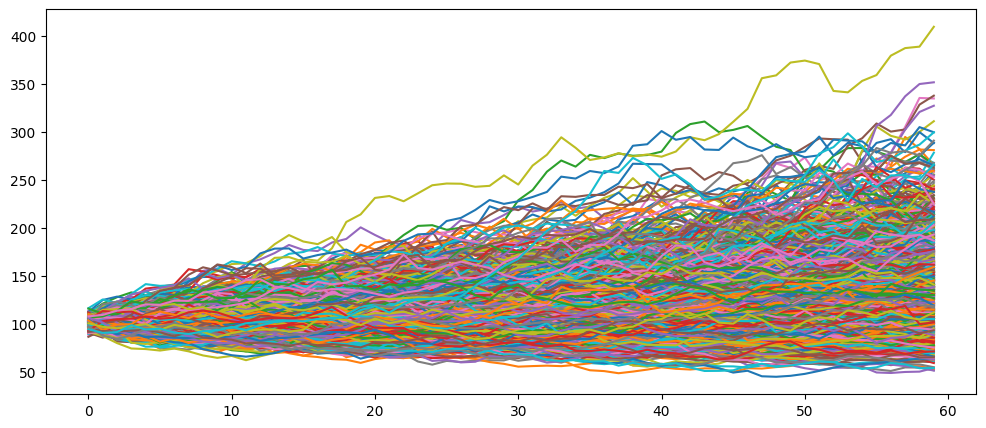

In [ ]:
gbm0(n_years=5, n_scenarios=1000, mu=0.07).plot(figsize=(12,5), legend=False)

In [ ]:
%timeit gbm0(n_years=5, n_scenarios=1000, mu=0.07)

3.08 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## **Interactive CPPI Monte Carlo Testing**

For the group to use today, let's examine an example of a Monte Carlo simulator which contains interactive components. We will be constructing a **constant proportion portfolio insurance** strategy, which is a dynamic portfolio insurance strategy. In the CPPI structure, the investor’s downside risk is limited while retaining some upside potential if the market performs well.

We are also including code in the below section which enables the use of `widgets`, a package that puts customizable slider bars into a visualization so we can observe how it evolves when we change some of the input variables.

To start, let's use our `gbm0` package to generate 10 scenarios in the data, at a drift value $\mu = 2$ and a volatility value of $\sigma = 3$:

In [ ]:
prices =  gbm0(n_scenarios=10, mu=2, sigma=3, s_0=2)
prices

,0,1,2,3,4,5,6,7,8,9
0,4.126054,-0.171034,1.619951e+00,3.396801,0.675811,2.339412e+00,3.551140,3.932338,6.033572,9.530200e-01
1,4.405474,-0.147586,1.340078e+00,5.826572,0.322583,2.254724e+00,2.650023,7.750217,7.633426,2.572649e+00
2,1.562884,-0.080405,1.298744e+00,8.178219,0.778440,2.625032e+00,3.852238,13.232842,19.309888,2.035196e+00
3,0.925341,-0.121746,1.769384e+00,13.161969,1.781162,4.723741e+00,4.545261,29.686657,15.655699,1.302135e+00
4,1.228301,0.034690,1.829166e+00,9.793600,2.157568,9.603615e+00,2.255305,25.004267,6.925748,4.036522e+00
...,...,...,...,...,...,...,...,...,...,...
115,-31.230557,-0.000017,1.004759e-08,0.000006,0.016930,1.670791e+08,24673.506136,-0.130622,-0.000150,8.861509e-12
116,-6.490823,-0.000034,7.991233e-09,0.000011,0.040132,1.800279e+08,49725.457594,-0.158415,-0.000016,1.909879e-11
117,-0.189833,-0.000057,1.987847e-08,-0.000007,0.057817,-2.219576e+08,75490.805479,-0.073120,-0.000021,4.271437e-11
118,-0.336900,-0.000004,3.246634e-08,-0.000006,0.087515,-6.115222e+08,73328.607820,-0.146254,-0.000017,3.456317e-11


Next, let's take our code from above and turn it into another function, this time

In [ ]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices =  gbm0(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=100, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred', alpha=0.2)


In [ ]:
import ipywidgets as widgets
from IPython.display import display
gbm_controls = widgets.interactive(show_gbm,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=1, value=1),
                                   mu=(0., +.2,.01),
                                   sigma=(0, .3, .01)
)

interactive(children=(IntSlider(value=1, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.1, d…

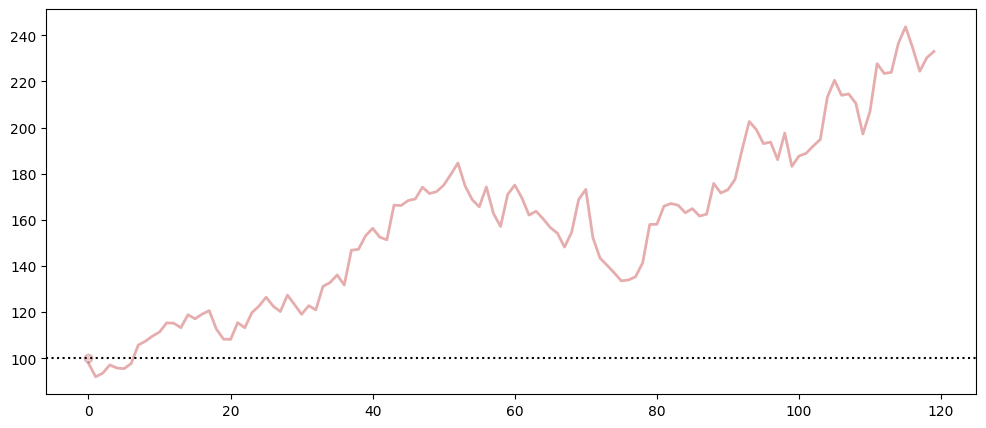

In [ ]:
display(gbm_controls)

## **Monte Caro Simulations for Multiple Stocks**

To start, let's examine some of the code we've used before to pull historic returns for Google, dating back to 2014. We'll then create two plots, the first of which displays the stock price and the second a distribution of the Daily Log Returns.

In [ ]:
# pip install yfinance

In [ ]:
import yfinance as yf
tickers_list = ['GOOG']
data = yf.download(tickers_list, start='2014-01-01', end='2022-01-01', interval = '1d')['Adj Close']


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

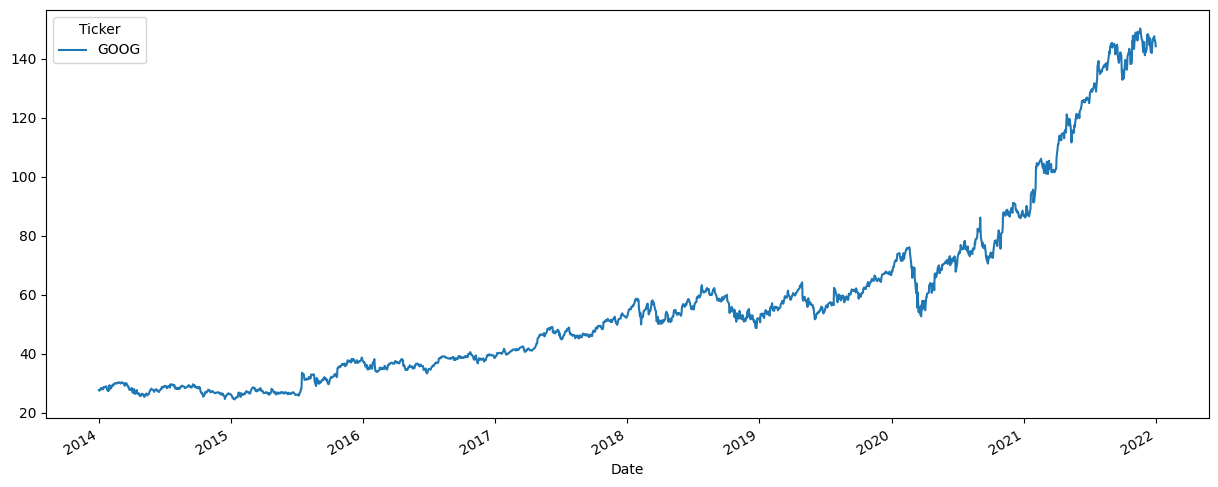

In [ ]:
data.plot(figsize=(15,6))

This method is straightforward and simple. Using pandas_datareader, you can import stock data for free and without access keys. Highly convenient for our purposes!

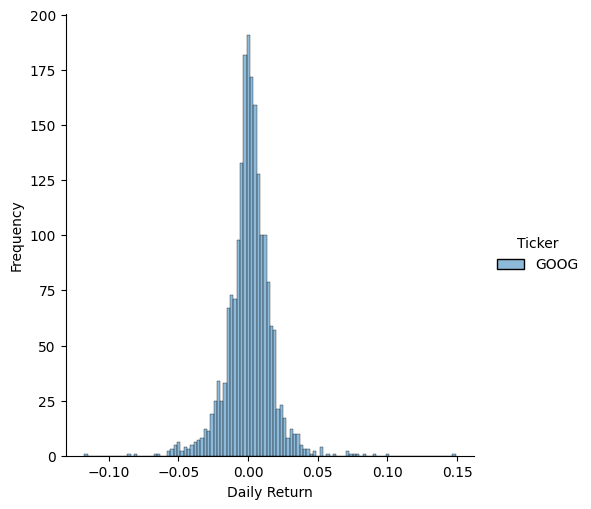

In [ ]:
log_returns = np.log(1 + data.pct_change())
#Plot
sns.displot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

Now let's compute the drift for our returns, as well as the variance and daily returns mean. These variables will be used in producing the core from which Monte Carlo Simulations can be carried out across Google stock returns.

In [ ]:
u = log_returns.mean().iloc[0]
var = log_returns.var().iloc[0]
drift = u - (0.5*var)
stdev = log_returns.std().iloc[0]
days = 50
trials = 100
Z = norm.ppf(np.random.rand(days, trials)) #days, trials
daily_returns = np.exp(drift + stdev * Z)

In this step we have to generate random variables for every day forecasted and for every simulation trial we will run.

In [ ]:
stdev = log_returns.std().iloc[0]
days = 50
trials = 100
Z = norm.ppf(np.random.rand(days, trials)) #days, trials
daily_returns = np.exp(drift + stdev * Z)

Now that we have randomly generated 50 random variables for each of the days in every one of the ten thousand trials, all we need is to calculate the price path for each of the trials!

In [ ]:
price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

In [ ]:
price_paths.shape

(50, 100)

There it goes! We’ve ran a Monte Carlo simulation that predicts Google’s stock price 50 days into the future.

<Axes: >

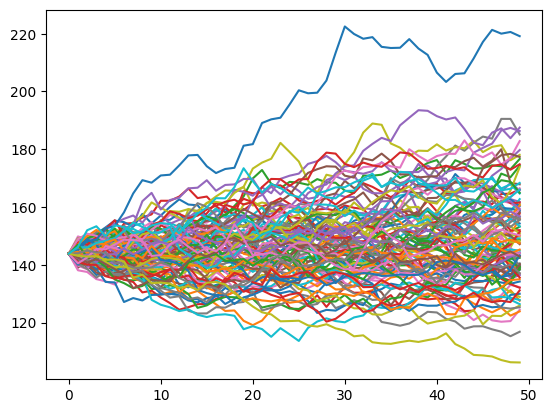

In [ ]:
pd.DataFrame(price_paths).plot(legend=None)

## **Your Work Starts Here**

For the next set of questions, use the code developed in the section above.

## 1) Pull daily data for `TSLA` from `2015-01-01` until `2022-01-01` and produce a dataframe storing the log returns for this stock.

## 2) Visualize these log returns in a histogram of frequencies, then determine the `drift`, `u`, and `variance` of them.

## 3) In the same way as we did with the `GOOG` stock, generate simulations for `TSLA` stock based on these variables. Calculate retruns for 100 days into the future, drawing 200 trials.

## 4) What was the maximum price that one of your simulations reached? How about minimum? What was the average after 100 days of simulated returns?

## 5) BONUS: Figure out the standard deviation of these returns and construct a 95% confidence interval for where TSLA stock will be 100 days in the future.

As a reminder, to create a confidence interval, we use the formula $\bar{x} +/- z_x \frac{\sigma}{\sqrt{n}}$, where $\bar{x}$ is the average of a dataset, the $z_x$ for a 95% confidence interval is 1.96, $\sigma$ is the standard deviation of a dataset, and $n$ is the number of observations.